In [1]:
import os
import re
import nltk
import torch
import spacy
import random
import hdbscan
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from plotnine import *
from tqdm import trange
from hyperopt import hp
from umap.umap_ import UMAP
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from src.utils.topic_modelling import *
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import RobertaTokenizer, RobertaModel
from mizani.formatters import percent_format, label_comma
from sklearn.feature_extraction.text import CountVectorizer
from hyperopt import STATUS_OK, fmin, tpe, space_eval, Trials

warnings.filterwarnings('ignore')

c:\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
c:\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
c:\Python311\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The imp

In [2]:
# Data
gral_path = os.path.abspath("")
input_path = os.path.join(gral_path,'data','inputs','processed')
output_path = os.path.join(gral_path,'data','inputs','labeled')
notas_df = pd.read_csv(os.path.join(input_path,'notas_prensa_bcrp.csv'), encoding='utf8')

# Exploring Our Sentences
After exploring word frequency using n-grams we will reduce the number of words used to express certain phrases without altering the meaning of the sentence.

In [3]:
# N-grams
notas_df['MONOGRAMS'] = notas_df['NOTA_WSW'].apply(lambda x: generate_ngrams(x,n=1))
notas_df['BIGRAMS'] = notas_df['NOTA_WSW'].apply(lambda x: generate_ngrams(x,n=2))
notas_df['TRIGRAMS'] = notas_df['NOTA_WSW'].apply(lambda x: generate_ngrams(x,n=3))
notas_df['QUADRIGRAMS'] = notas_df['NOTA_WSW'].apply(lambda x: generate_ngrams(x,n=4))

In [4]:
# Understanding word/phrase frequency
x = 'MONOGRAMS'
freq_df = pd.DataFrame(notas_df[x].explode())
freq_df = freq_df.groupby(x).agg(N = pd.NamedAgg(x,'count')).reset_index(drop=False)
freq_df = freq_df.sort_values('N',ascending=False).reset_index(drop=True)
freq_df['N_CUM'] = freq_df['N'].cumsum()
freq_df['PCT'] = freq_df['N_CUM']/np.sum(freq_df['N'])

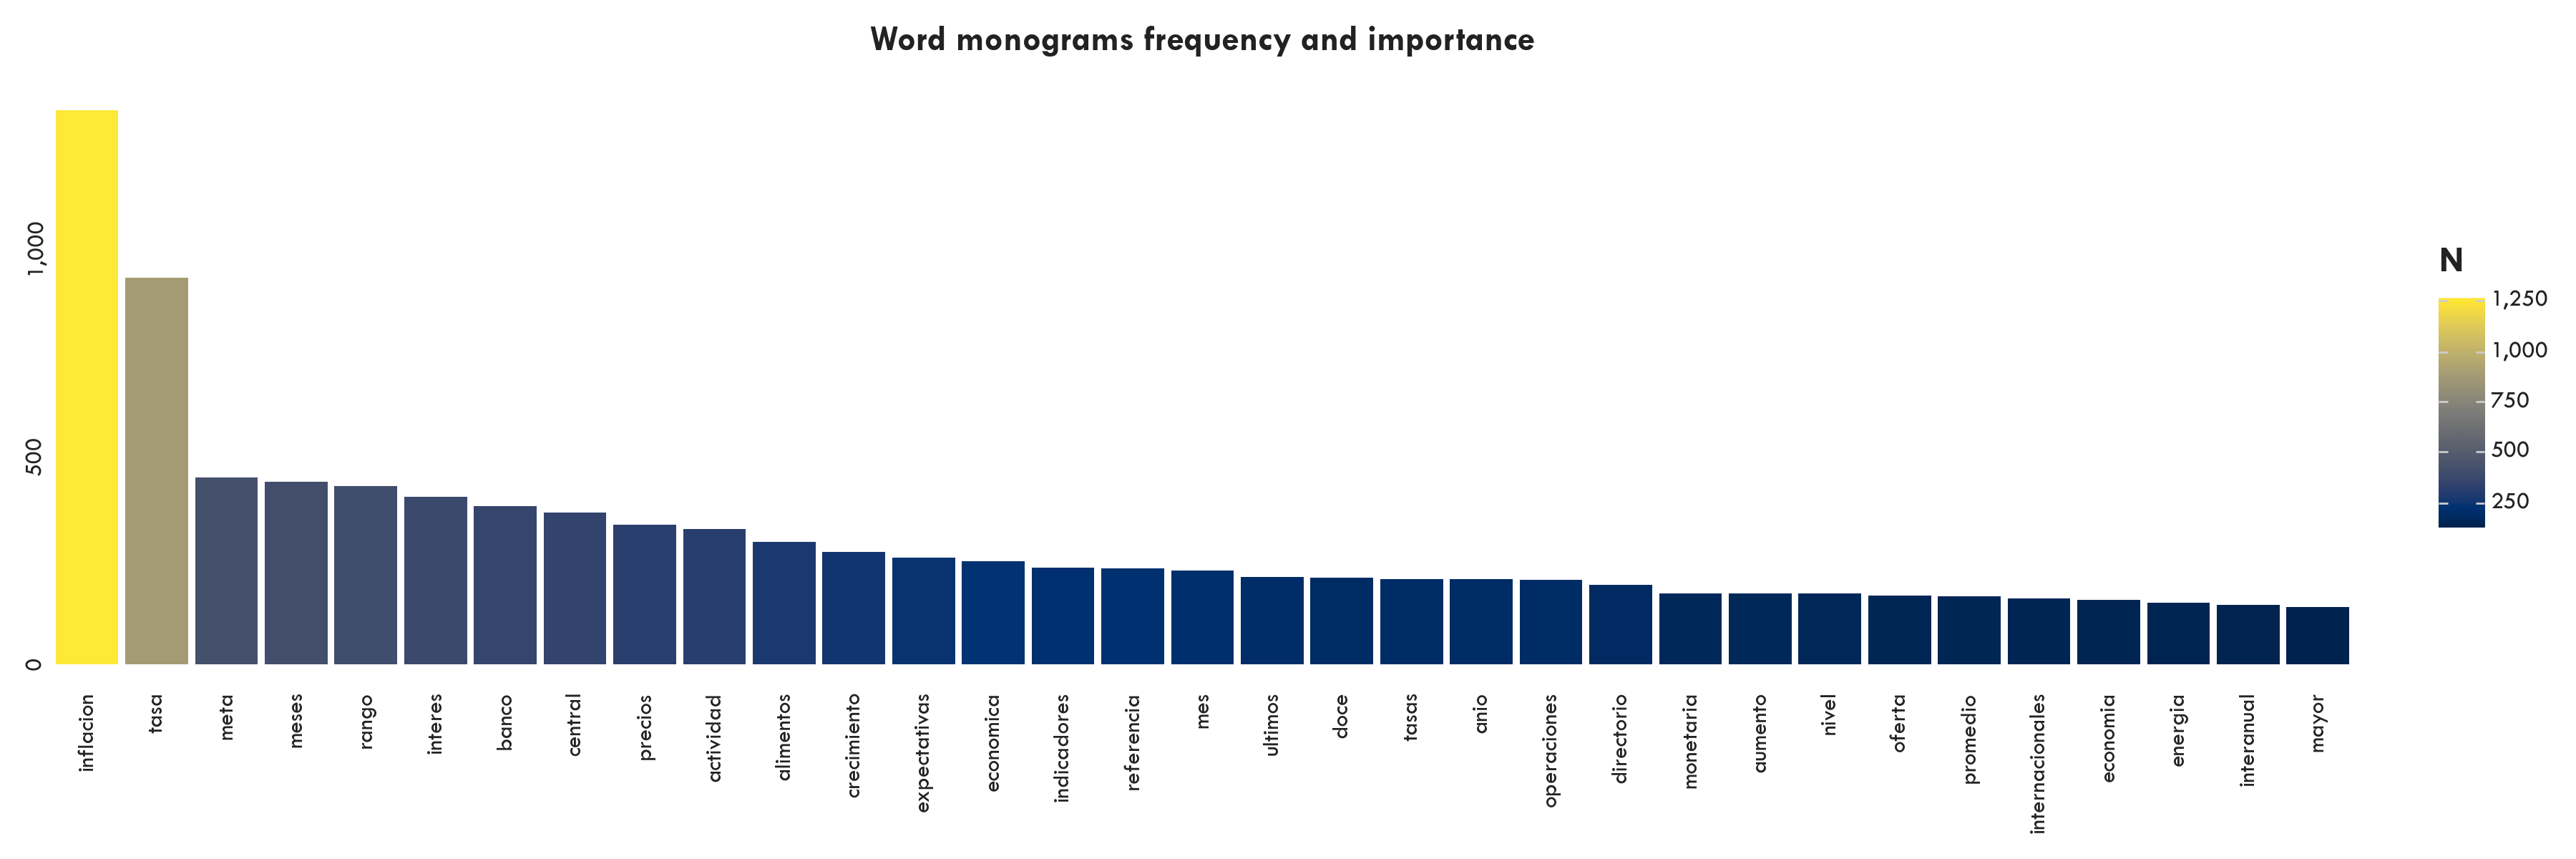

In [5]:
threshold = 1/3
plot = ggplot(freq_df[freq_df['PCT']<=threshold])
plot = plot + geom_bar(aes(f'reorder({x},-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Word {x.lower()} frequency and importance')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

In [6]:
# Understanding word/phrase frequency
x = 'BIGRAMS'
freq_df = pd.DataFrame(notas_df[x].explode())
freq_df = freq_df.groupby(x).agg(N = pd.NamedAgg(x,'count')).reset_index(drop=False)
freq_df = freq_df.sort_values('N',ascending=False).reset_index(drop=True)
freq_df['N_CUM'] = freq_df['N'].cumsum()
freq_df['PCT'] = freq_df['N_CUM']/np.sum(freq_df['N'])

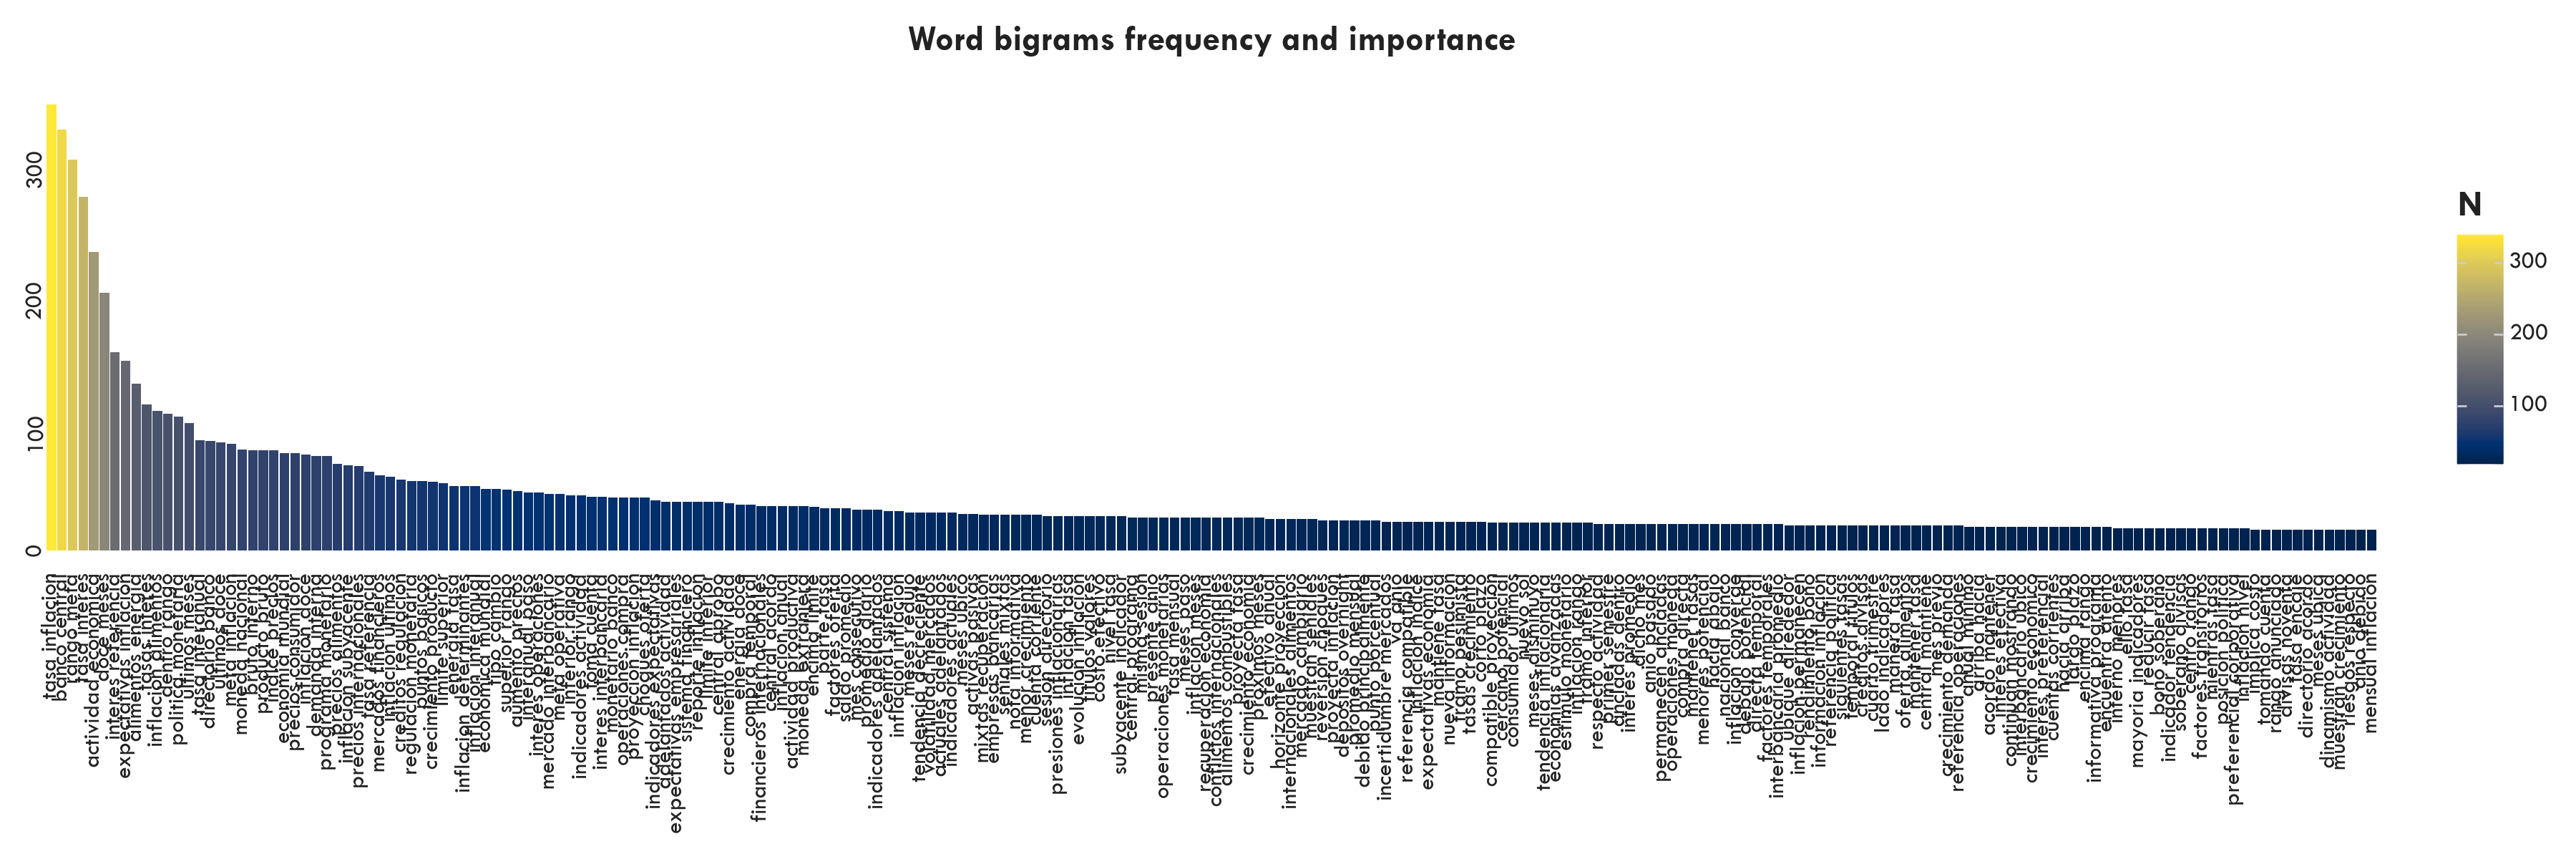

In [7]:
threshold = 1/3
plot = ggplot(freq_df[freq_df['PCT']<=threshold])
plot = plot + geom_bar(aes(f'reorder({x},-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Word {x.lower()} frequency and importance')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

In [8]:
# Understanding word/phrase frequency
x = 'TRIGRAMS'
freq_df = pd.DataFrame(notas_df[x].explode())
freq_df = freq_df.groupby(x).agg(N = pd.NamedAgg(x,'count')).reset_index(drop=False)
freq_df = freq_df.sort_values('N',ascending=False).reset_index(drop=True)
freq_df['N_CUM'] = freq_df['N'].cumsum()
freq_df['PCT'] = freq_df['N_CUM']/np.sum(freq_df['N'])

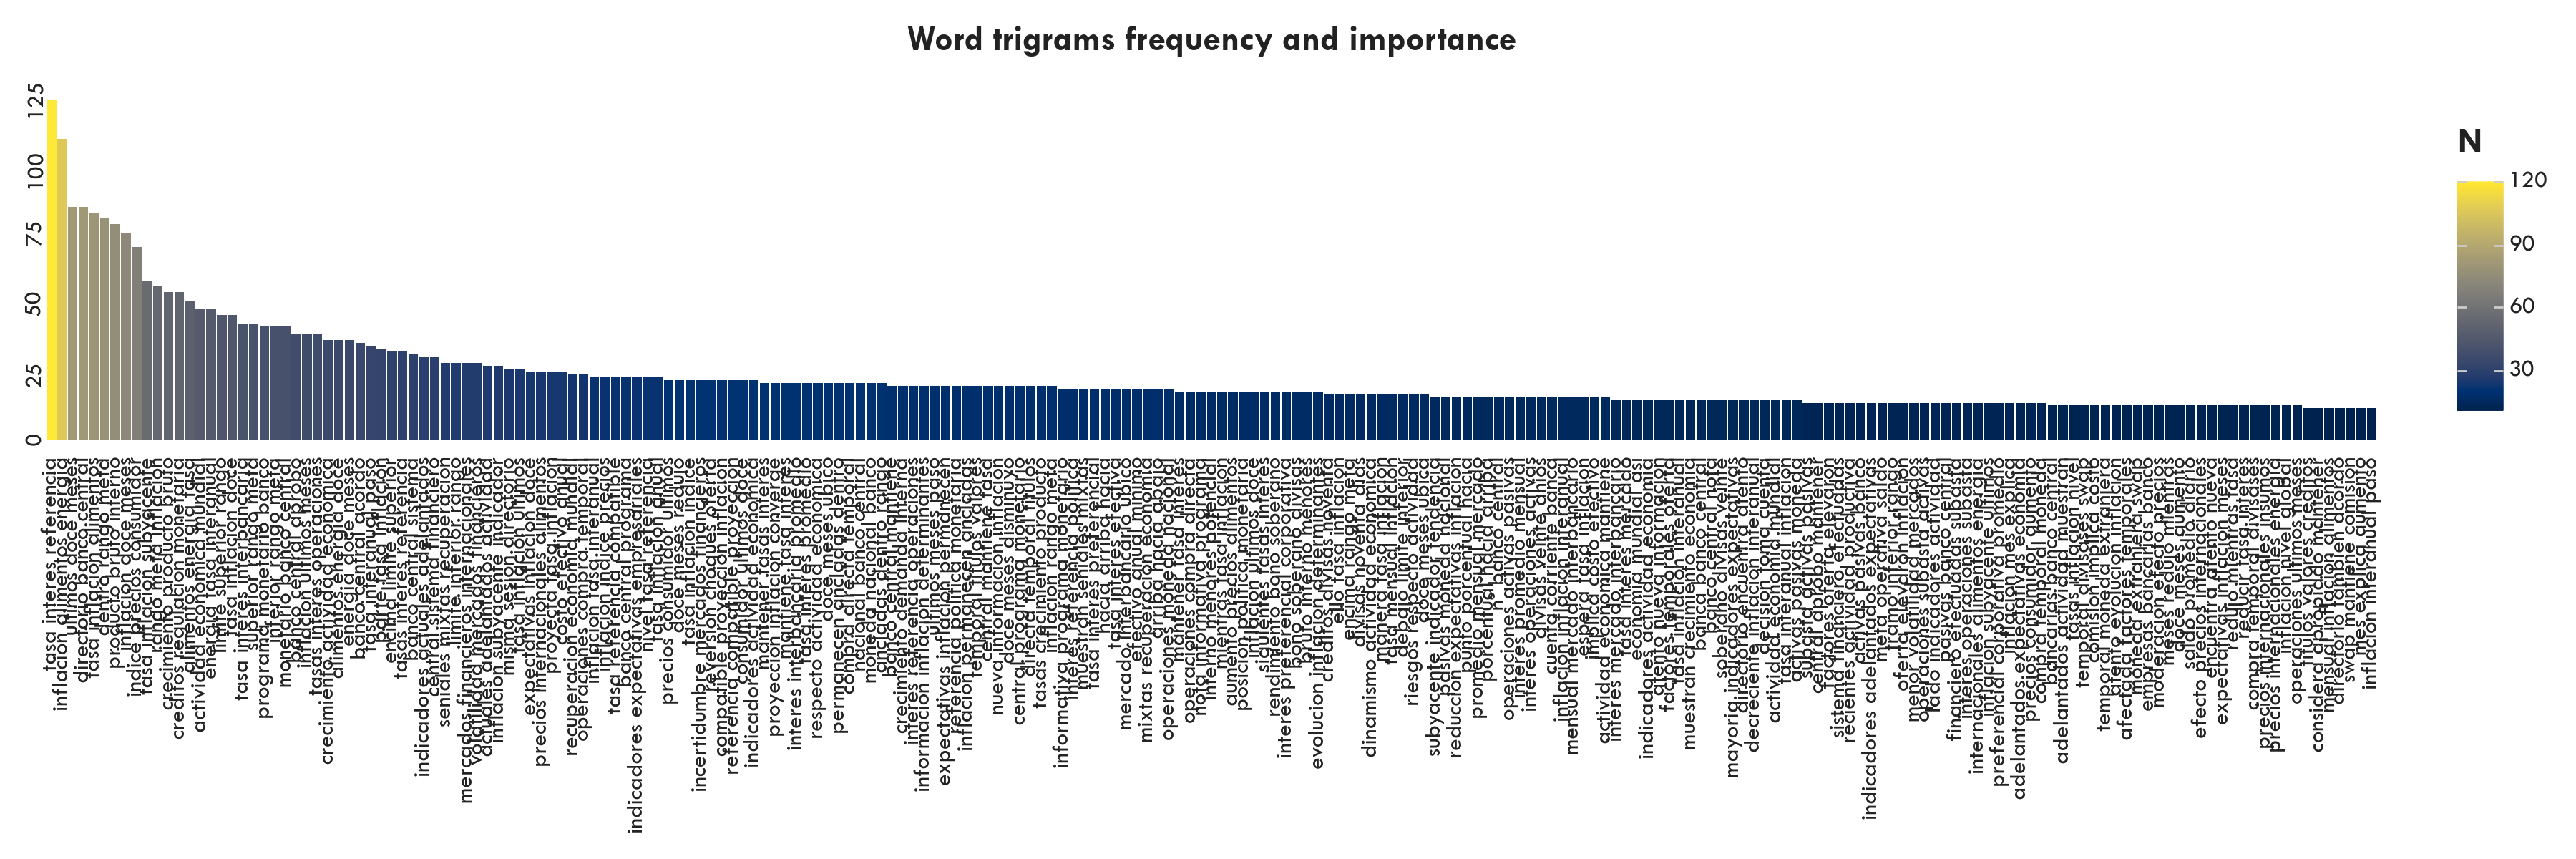

In [9]:
threshold = 1/5
plot = ggplot(freq_df[freq_df['PCT']<=threshold])
plot = plot + geom_bar(aes(f'reorder({x},-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Word {x.lower()} frequency and importance')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

In [10]:
# Understanding word/phrase frequency
x = 'QUADRIGRAMS'
freq_df = pd.DataFrame(notas_df[x].explode())
freq_df = freq_df.groupby(x).agg(N = pd.NamedAgg(x,'count')).reset_index(drop=False)
freq_df = freq_df.sort_values('N',ascending=False).reset_index(drop=True)
freq_df['N_CUM'] = freq_df['N'].cumsum()
freq_df['PCT'] = freq_df['N_CUM']/np.sum(freq_df['N'])

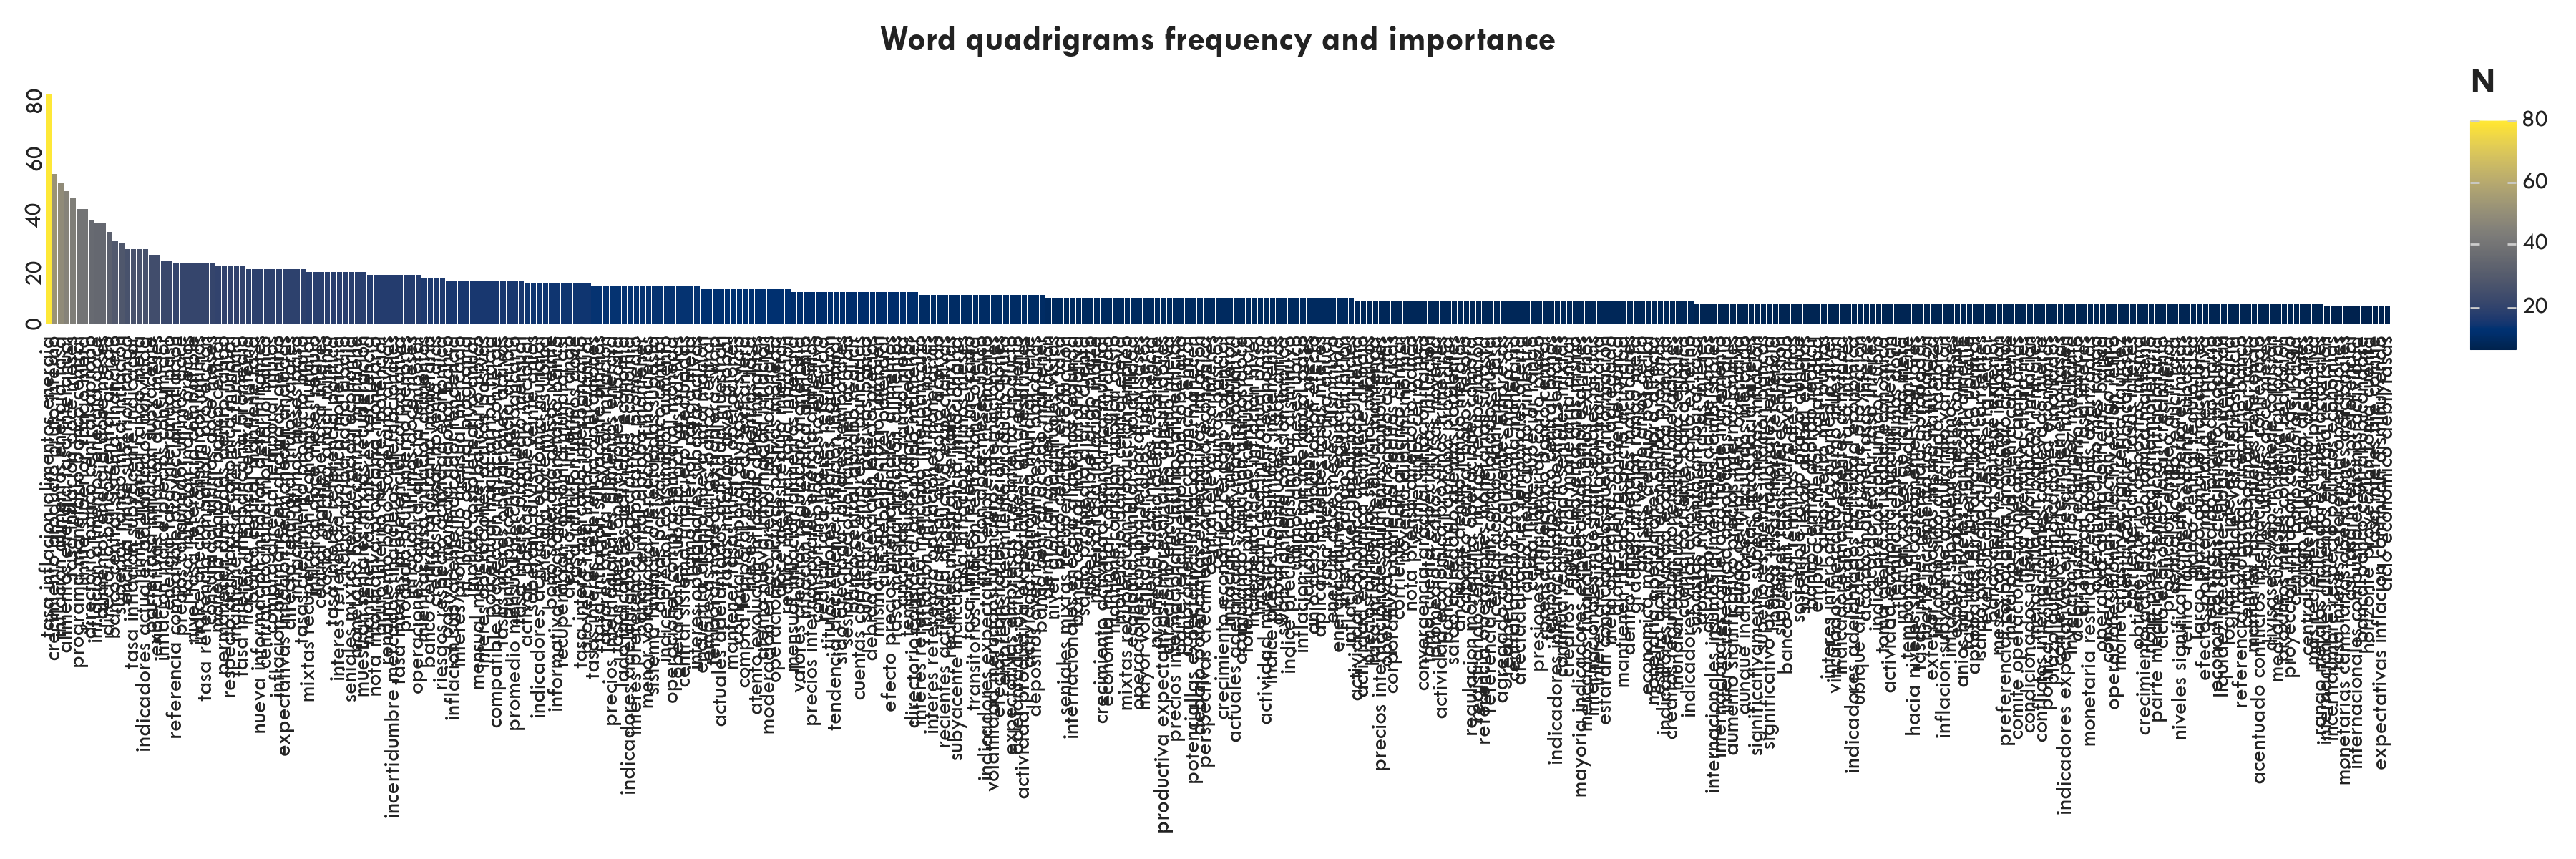

In [11]:
threshold = 1/5
plot = ggplot(freq_df[freq_df['PCT']<=threshold])
plot = plot + geom_bar(aes(f'reorder({x},-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Word {x.lower()} frequency and importance')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

# Topic Modelling
The goal of this notebook is to explore what kind of topics we can find in the data after processing and cleaning the Monetary Program Communication by the Peruvian Central Bank. The hypothesis is that the Central Bank mainly talks about inflation in its monthly communication but also mentions forward-looking expectations about economic growth. We are also expected to find other topics related to operational practices. These are the reasons why we will explore different numbers of topics to assess the quality of the clusters.

## Contextual word embeddings (CWEB)
Different pretrained transformer-based models are evaluated. These models can classified as BERT-based models and RoBERTa-based models. The key difference between these two architectures is that in RoBERTa, the masking is performed during training time whereas in BERT the masking is performed at the beginning of the training. The architectures based on BERT are: (i) BETO, the Spanish version of BERT; two novel lightweight versions: (ii) ALBETO and (iii) Distilled BETO, and (iv) multilingual BERT (mBERT). The architectures based on RoBERTa are (i) MarIA, (ii) BERTIN and (iii) XLM. It is important to bear in mind that given that these kinds of embeddings are very time consuming, they are difficult to combine with other feature sets. Therefore, the fixed representation of the [CLS] token is extracted. Then, this representation is used to combine the contextual embeddings more easily with the rest of the feature sets. Preliminary results indicate that the precision, recall, and accuracy of both contextual word and sentence embeddings are similar with this and other datasets.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
model = RobertaModel.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', output_hidden_states=True)
print(f"Device available: {device}")

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device available: cuda


In [13]:
# Get all the hidden states
sentences = notas_df['NOTA_TK'].to_list()
tokens = tokenizer(sentences,return_tensors='pt',padding=True)

model.eval()
with torch.no_grad():
    out = model(**tokens)

hidden_states = out[2]

In [14]:
n,l,hd = hidden_states[-1].shape
last_hidden_state_tensor = torch.mean(hidden_states[-1], dim=1).squeeze()
print(f'Batch size of {n}, sequence length of {l}, and {hd} features')

Batch size of 2017, sequence length of 142, and 768 features


In [15]:
# Getting the embeddings
ids = notas_df.index.to_list()
texts = last_hidden_state_tensor.cpu().tolist()
content = {idx:val for idx, val in zip(ids,texts)}
cweb_df = pd.DataFrame.from_dict(content,orient='index')

In [20]:
# Bayesian optimization
hspace = {
'n_neighbors':hp.choice('n_neighbors',range(3,16)),
'n_components':hp.choice('n_components',range(3,16)),
'min_cluster_size':hp.choice('min_cluster_size',range(10,100)),
'min_samples':hp.choice('min_samples',range(1,20)),
'cluster_selection_method':hp.choice('cluster_selection_method',['eom','leaf']),
'metric':'euclidean',
'random_state':42
}

label_lower = 5
label_upper = 20
max_evals = 100
penalty_val = 0.05

best_param_use, best_cluster_use, trial_use = bayesian_search(cweb_df,space=hspace,label_lower=label_lower,label_upper=label_upper,max_evals=max_evals,penalty_val=penalty_val)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [18:19<00:00, 10.99s/trial, best loss: 0.0074367873078829945]
Best parameters:
{'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 30, 'min_samples': 18, 'n_components': 11, 'n_neighbors': 10, 'random_state': 42}
Label count: 5


In [21]:
# Visualize the results
cweb_df_red = UMAP(n_neighbors=50,n_components=2,metric='cosine').fit_transform(cweb_df)
cweb_df_viz = pd.DataFrame(cweb_df_red, columns=['X', 'Y'])
cweb_df_viz['LABELS'] = best_cluster_use.labels_

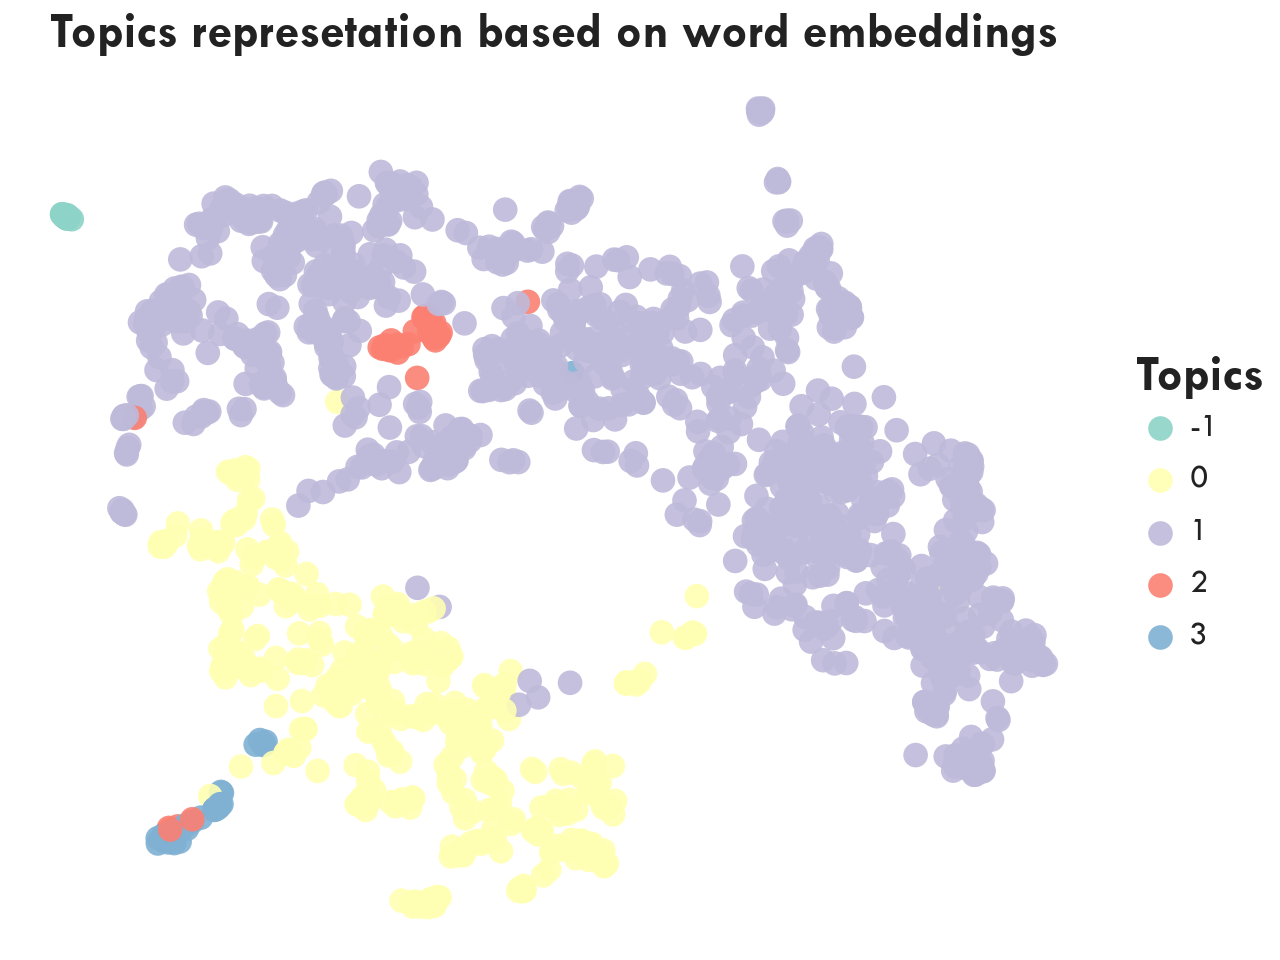

In [22]:
plot = ggplot(cweb_df_viz,aes(x='X',y='Y'))
plot = plot + ggtitle('Topics represetation based on word embeddings')
plot = plot + geom_point(aes(color='factor(LABELS)'), stroke=0, alpha=0.9, size=5)
plot = plot + scale_color_brewer(name='Topics',palette=8,type='qual')
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

In [23]:
# Topic creation
nlp = spacy.load('es_core_news_md')
topic_cweb = notas_df.copy()
topic_cweb['LABELS'] = best_cluster_use.labels_

In [25]:
topic_cweb = topic_cweb.groupby('LABELS').agg(OBS=pd.NamedAgg(column='NOTA_WSW', aggfunc='count'),TOPIC=pd.NamedAgg(column='NOTA_WSW', aggfunc=partial(extract_labels,nlp=nlp))).reset_index(drop=False)
print(topic_cweb)

   LABELS   OBS                     TOPIC
0      -1    15       ubica_alimento_tasa
1       0   523     acordo_tasa_operación
2       1  1394         proyecta_tasa_mes
3       2    35          ubico_tasa_rango
4       3    50  mantiene_tasa_referencia


In [27]:
# Topic creation
sentences = notas_df['NOTA_WSW'].to_list()
docs_df = pd.DataFrame(sentences, columns=['SENTENCES'])
docs_df['TOPICS'] = best_cluster_use.labels_
docs_df['ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['TOPICS'], as_index = False).agg({'SENTENCES': ' '.join})
tf_idf, count = c_tf_idf(docs_per_topic.SENTENCES.values, m=len(texts))

In [28]:
# Topic representation
n = 20
words = count.get_feature_names_out()
labs = list(docs_per_topic.TOPICS)
tf_idf_transposed = tf_idf.T
indices = tf_idf_transposed.argsort()[:, -n:]
top_n_words = {lab: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, lab in enumerate(labs)}

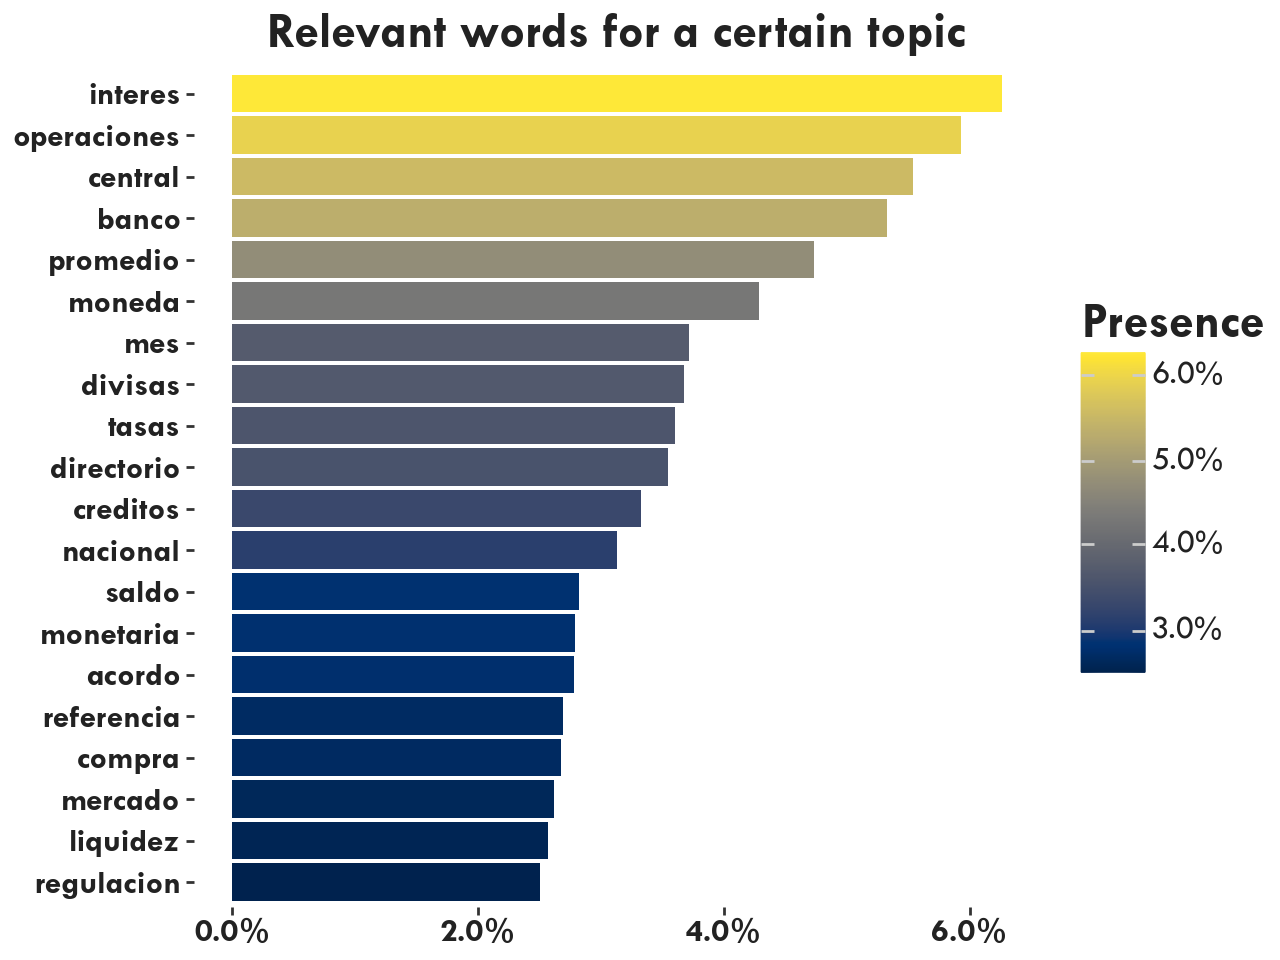

In [29]:
topic = 0
data_plot = pd.DataFrame.from_dict(top_n_words[topic])
data_plot.columns = ['WORD','Presence']
plot = ggplot(data_plot,aes('reorder(WORD, Presence)','Presence',fill='Presence'))
plot = plot + geom_bar(stat='identity')
plot = plot + ggtitle('Relevant words for a certain topic')
plot = plot + coord_flip()
plot = plot + scale_y_continuous(labels=percent_format(accuracy=.1))
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=percent_format(accuracy=.1))
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",face='bold'),axis_title=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

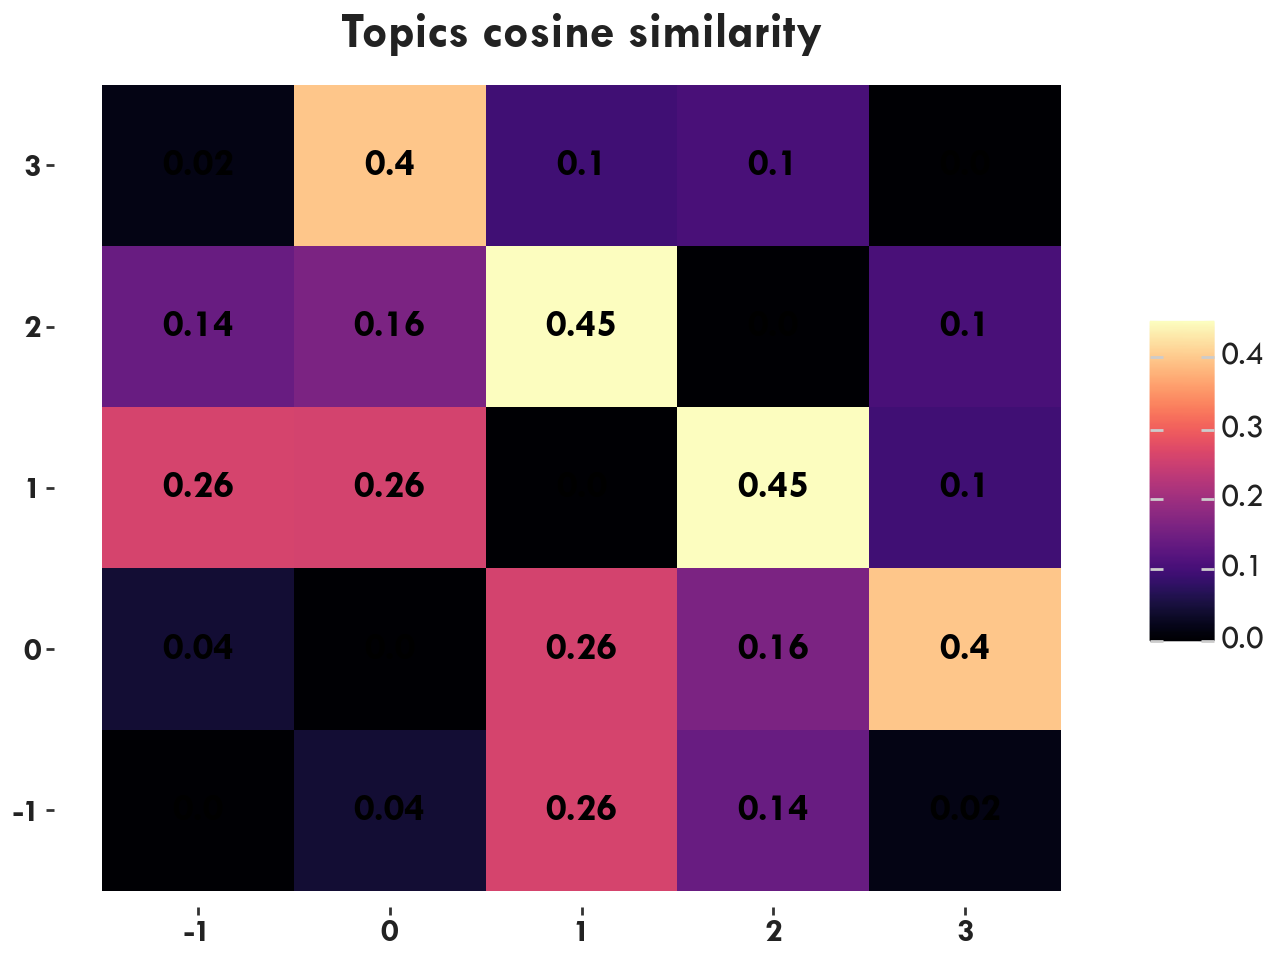

In [30]:
# Similarity among topics
similarities = cosine_similarity(tf_idf.T)
np.fill_diagonal(similarities, 0)
labs = docs_per_topic['TOPICS']
similarities = pd.DataFrame(similarities,columns=labs,index=labs).reset_index(drop=False).melt(id_vars='TOPICS',var_name='TOPIC_',value_name='Cosine Sim.')
similarities['lab_text'] = similarities['Cosine Sim.'].round(2)

plot = ggplot(similarities,aes('TOPICS','TOPIC_',fill='Cosine Sim.'))    
plot = plot + geom_tile()
plot = plot + geom_text(aes('TOPICS','TOPIC_',label='lab_text'),show_legend=None, family='Tw Cen MT', fontweight='bold', size=14)
plot = plot + ggtitle('Topics cosine similarity')
plot = plot + scale_fill_continuous(cmap_name='magma')
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",face='bold'),axis_title=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_blank(),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

## Contextual sentence embeddings (CSEB)
Sentence-BERT (Bidirectional Encoder Representations from Transformers for Sentences) is a modification of the popular BERT model that is specifically designed for sentence embeddings. It is useful for topic modeling because it can generate high-quality, dense vector representations of sentences, capturing their semantic meaning and contextual information.

By using CSEB from Sentence-BERT, topic modeling algorithms can better capture the underlying semantic structures and identify latent topics more accurately. These embeddings can capture nuanced meanings, handle polysemy (words with multiple meanings), and consider the context in which words appear, leading to more meaningful and coherent topic clusters.

One reason for not using BERT is that the results showed that directly using the output of BERT leads to rather poor performances. Averaging the BERT embeddings achieves an average correlation of only 54.81, and using the [CLS] token output only achieves an average correlation of 29.19. Both are worse than computing average GloVe embeddings as stated in [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf).

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device=device)
print(f"Using device: {device}")

Using device: cuda


In [32]:
# Getting the embeddings
ids = notas_df.index.to_list()
texts = notas_df['NOTA_TK'].to_list()
content = {idx:val for idx, val in zip(ids,texts)}

cseb = {}
for idx, text in tqdm(content.items()):
    cseb[idx] = model.encode(text)

cseb_df = pd.DataFrame.from_dict(cseb,orient='index')

100%|██████████| 2017/2017 [00:41<00:00, 48.32it/s]


In [33]:
# Bayesian optimization
hspace = {
'n_neighbors':hp.choice('n_neighbors',range(3,16)),
'n_components':hp.choice('n_components',range(3,16)),
'min_cluster_size':hp.choice('min_cluster_size',range(10,100)),
'min_samples':hp.choice('min_samples',range(1,20)),
'cluster_selection_method':hp.choice('cluster_selection_method',['eom','leaf']),
'metric':'euclidean',
'random_state':42
}

label_lower = 5
label_upper = 20
max_evals = 100
penalty_val = 0.05

best_param_use, best_cluster_use, trial_use = bayesian_search(cseb_df,space=hspace,label_lower=label_lower,label_upper=label_upper,max_evals=max_evals,penalty_val=penalty_val)

100%|██████████| 100/100 [15:28<00:00,  9.29s/trial, best loss: 0.020823004462072386]
Best parameters:
{'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 89, 'min_samples': 6, 'n_components': 7, 'n_neighbors': 14, 'random_state': 42}
Label count: 7


In [34]:
# Visualize the results
cseb_df_red = UMAP(n_neighbors=50,n_components=2,metric='cosine').fit_transform(cseb_df)
cseb_df_viz = pd.DataFrame(cseb_df_red, columns=['X', 'Y'])
cseb_df_viz['LABELS'] = best_cluster_use.labels_

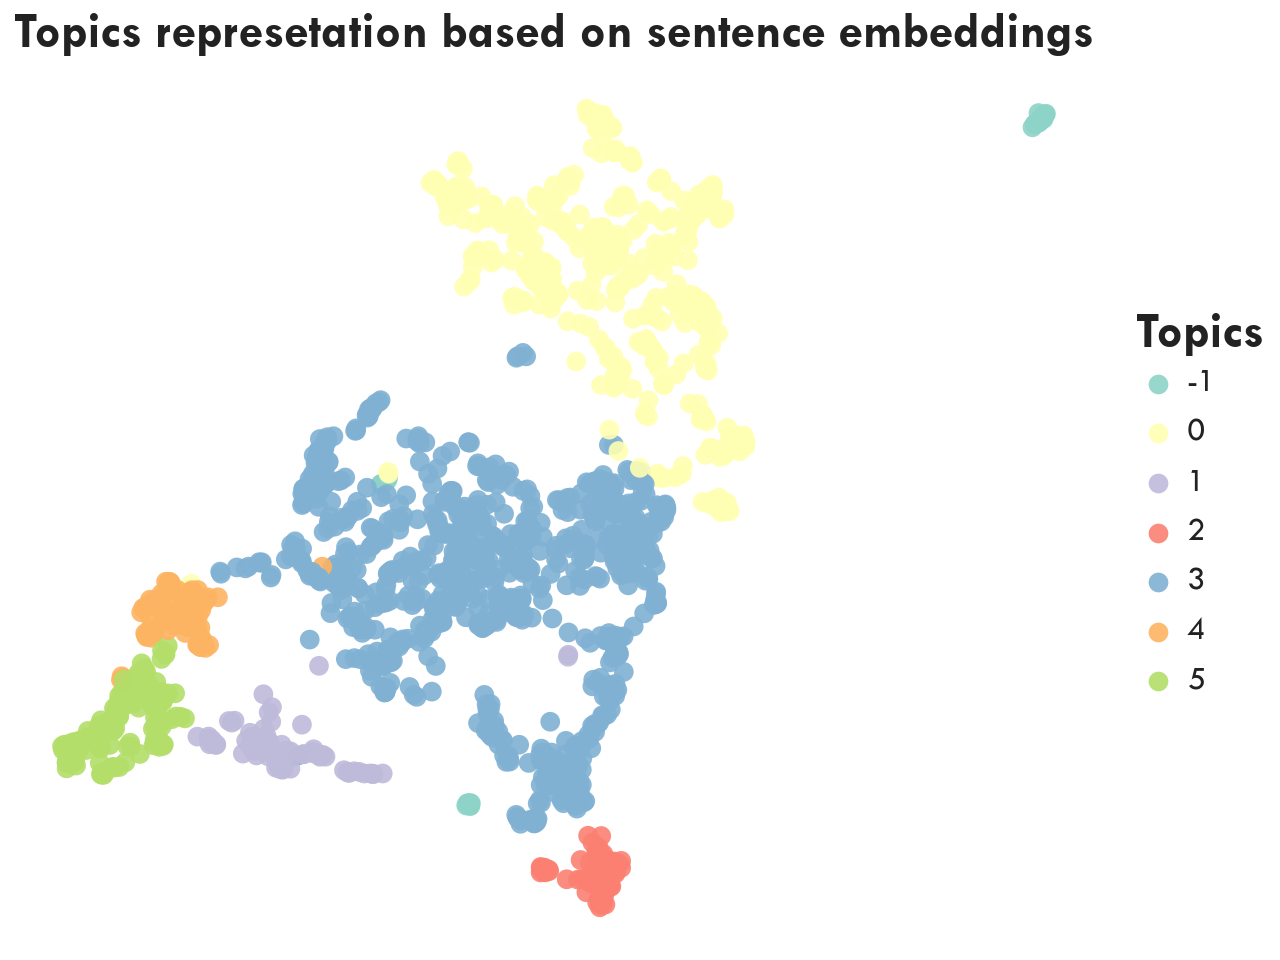

In [35]:
plot = ggplot(cseb_df_viz,aes(x='X',y='Y'))
plot = plot + ggtitle('Topics represetation based on sentence embeddings')
plot = plot + geom_point(aes(color='factor(LABELS)'), stroke=0, alpha=0.9, size=4)
plot = plot + scale_color_brewer(name='Topics',palette=8,type='qual')
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

In [36]:
# Topic creation
nlp = spacy.load('es_core_news_md')
topic_cseb = notas_df.copy()
topic_cseb['LABELS'] = best_cluster_use.labels_

In [37]:
topic_cseb = topic_cseb.groupby('LABELS').agg(OBS=pd.NamedAgg(column='NOTA_WSW', aggfunc='count'),TOPIC=pd.NamedAgg(column='NOTA_WSW', aggfunc=partial(extract_labels,nlp=nlp))).reset_index(drop=False)
print(topic_cseb)

   LABELS  OBS                             TOPIC
0      -1   42           implica_costo_operación
1       0  570                 acordo_tasa_banco
2       1   93    mantiene_crecimiento_actividad
3       2   91                tasa_tasa_alimento
4       3  970                 proyecta_tasa_mes
5       4   97  muestran_actividad_incertidumbre
6       5  154      muestran_indicador_actividad


In [38]:
# Topic creation
sentences = notas_df['NOTA_WSW'].to_list()
docs_df = pd.DataFrame(sentences, columns=['SENTENCES'])
docs_df['TOPICS'] = best_cluster_use.labels_
docs_df['ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['TOPICS'], as_index = False).agg({'SENTENCES': ' '.join})
tf_idf, count = c_tf_idf(docs_per_topic.SENTENCES.values, m=len(texts))

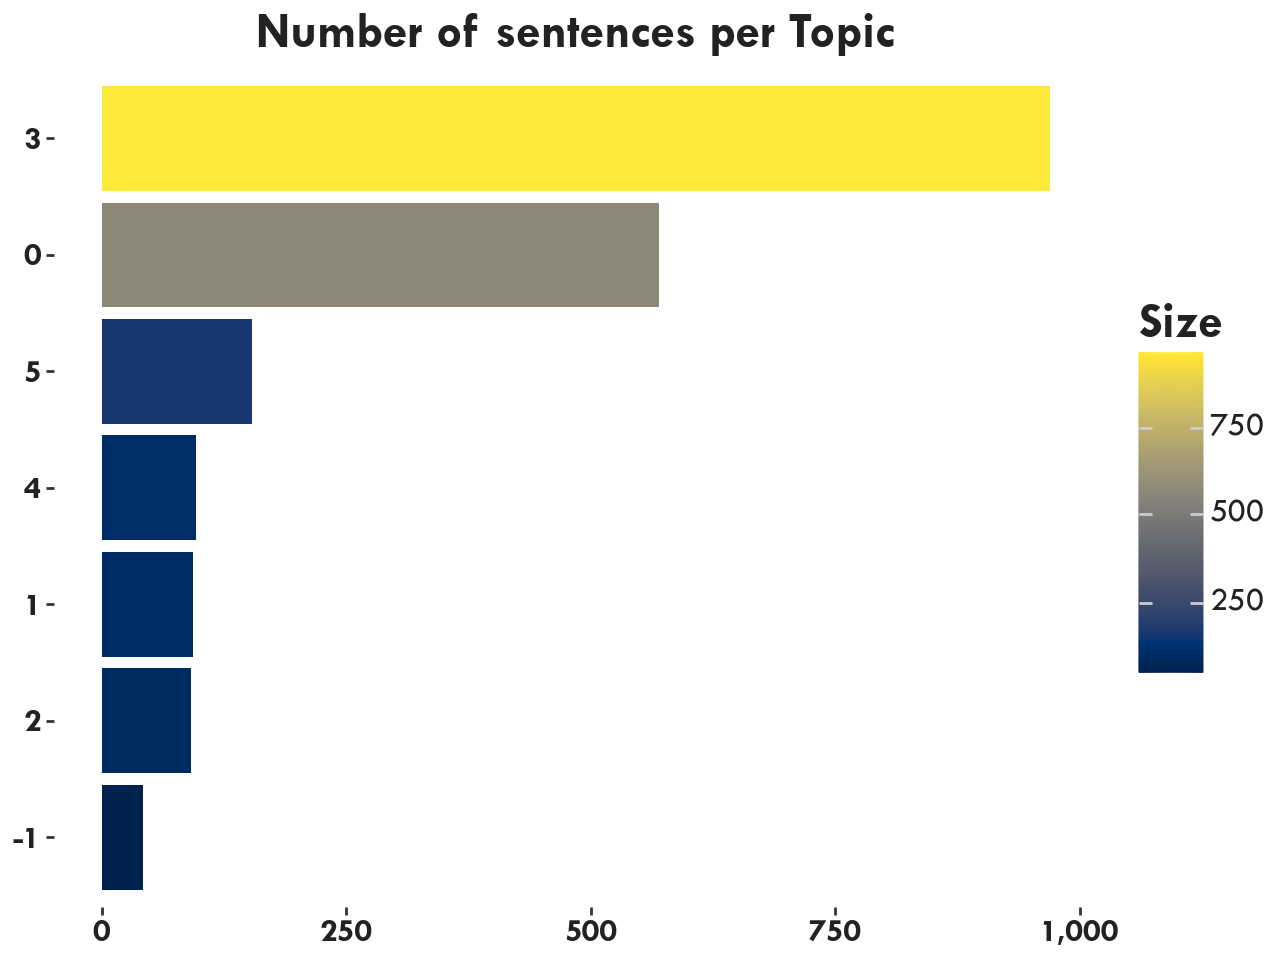

In [39]:
# Topic size
topic_sizes = (docs_df.groupby(['TOPICS'])
                    .SENTENCES
                    .count()
                    .reset_index()
                    .rename({"TOPICS": "Topic", "SENTENCES": "Size"}, axis='columns')
                    .sort_values("Size", ascending=False))

plot = ggplot(topic_sizes,aes('reorder(Topic, Size)','Size',fill='Size'))
plot = plot + geom_bar(stat='identity')
plot = plot + ggtitle('Number of sentences per Topic')
plot = plot + coord_flip()
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",face='bold'),axis_title=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

In [40]:
# Topic representation
n = 20
words = count.get_feature_names_out()
labs = list(docs_per_topic.TOPICS)
tf_idf_transposed = tf_idf.T
indices = tf_idf_transposed.argsort()[:, -n:]
top_n_words = {lab: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, lab in enumerate(labs)}

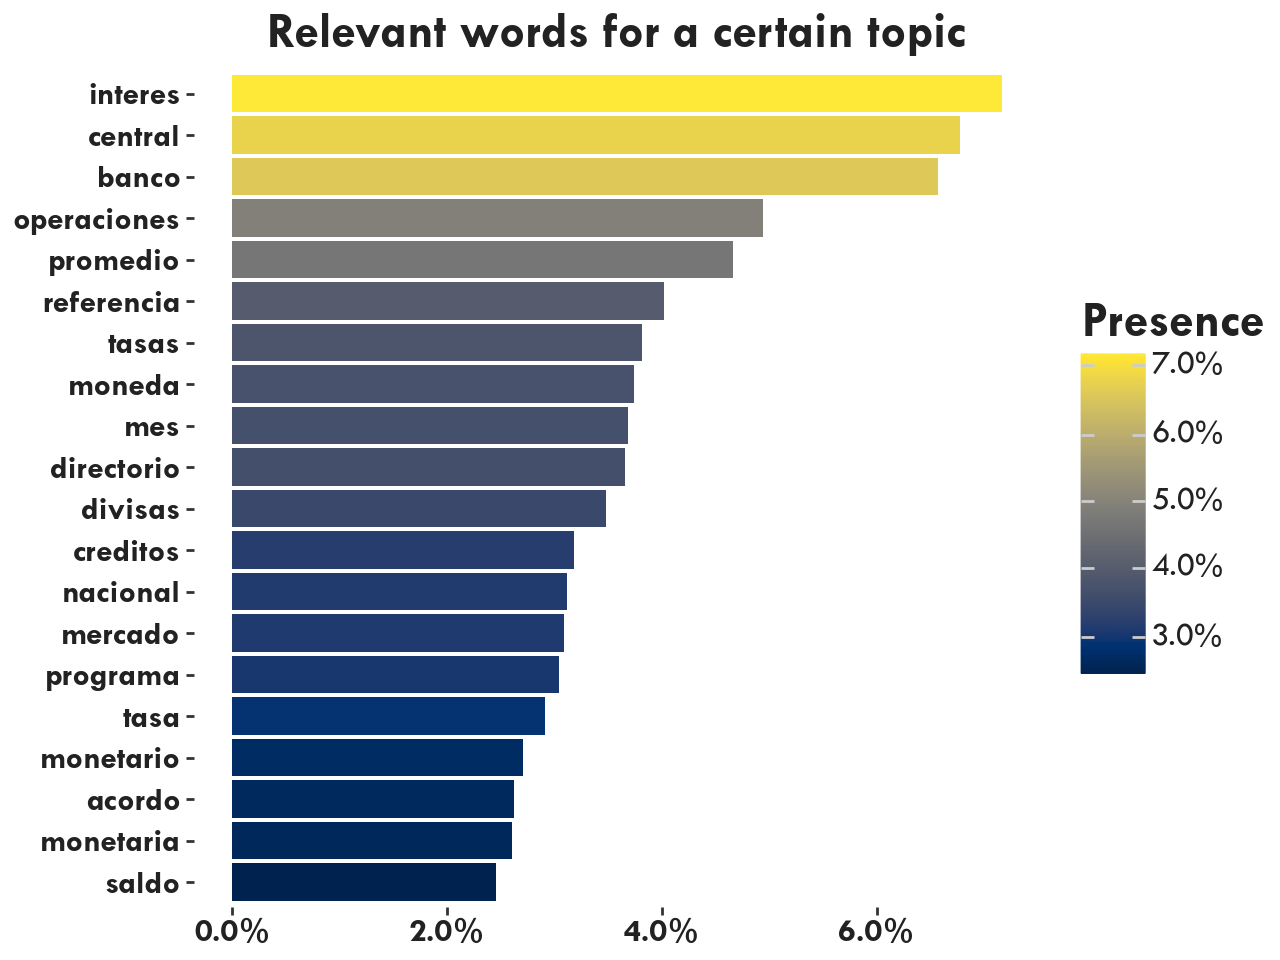

In [41]:
topic = 0
data_plot = pd.DataFrame.from_dict(top_n_words[topic])
data_plot.columns = ['WORD','Presence']
plot = ggplot(data_plot,aes('reorder(WORD, Presence)','Presence',fill='Presence'))
plot = plot + geom_bar(stat='identity')
plot = plot + ggtitle('Relevant words for a certain topic')
plot = plot + coord_flip()
plot = plot + scale_y_continuous(labels=percent_format(accuracy=.1))
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=percent_format(accuracy=.1))
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",face='bold'),axis_title=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

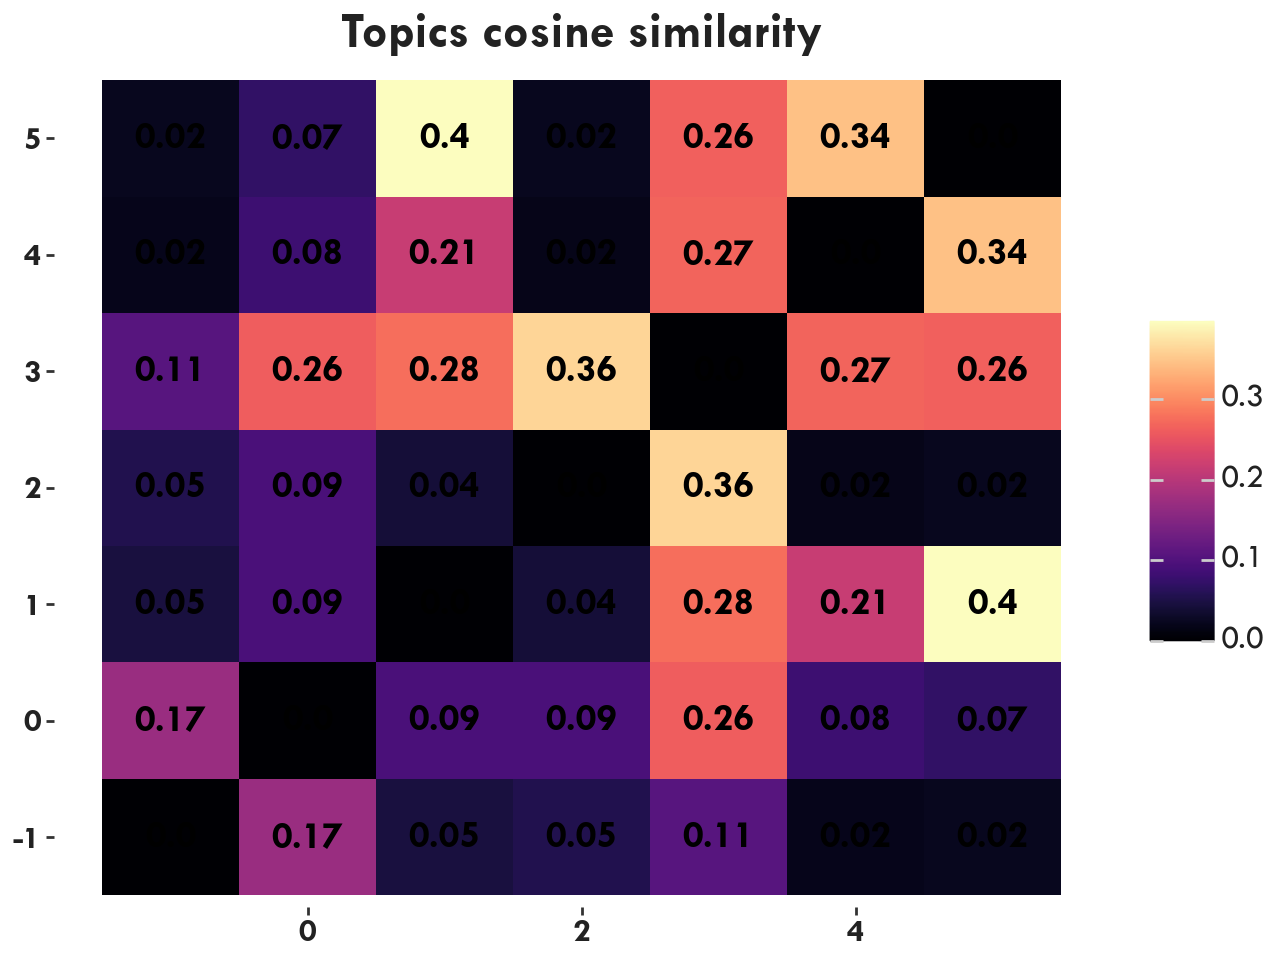

In [42]:
# Similarity among topics
similarities = cosine_similarity(tf_idf.T)
np.fill_diagonal(similarities, 0)
labs = docs_per_topic['TOPICS']
similarities = pd.DataFrame(similarities,columns=labs,index=labs).reset_index(drop=False).melt(id_vars='TOPICS',var_name='TOPIC_',value_name='Cosine Sim.')
similarities['lab_text'] = similarities['Cosine Sim.'].round(2)

plot = ggplot(similarities,aes('TOPICS','TOPIC_',fill='Cosine Sim.'))    
plot = plot + geom_tile()
plot = plot + geom_text(aes('TOPICS','TOPIC_',label='lab_text'),show_legend=None, family='Tw Cen MT', fontweight='bold', size=14)
plot = plot + ggtitle('Topics cosine similarity')
plot = plot + scale_fill_continuous(cmap_name='magma')
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",face='bold'),axis_title=element_blank())
plot = plot + theme(legend_background = element_blank(),legend_title=element_blank(),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot

In [43]:
# -----
# Store data, for further manual tagging on top of topic modelling 
notas_df['LABS'] = best_cluster_use.labels_
notas_df.to_csv(os.path.join(output_path,'notas_prensa_bcrp.csv'),index=False,encoding='utf-8')